### Instalacja i importowanie niezbędnych bibliotek



In [1]:
!pip install pygame
import numpy as np 
import pandas as pd
import cv2
import time
import matplotlib.pyplot as plt
import pickle
import pygame
import tensorflow as tf
from tensorflow.keras.models import load_model

pygame 2.0.1 (SDL 2.0.14, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


**Jeśli notatnik uruchamiany jest w środowisku Google Colaboratory, należy uruchomić poniższe dwie komórki:**

In [ ]:
!pip install opencv-python==4.5.1.48

In [ ]:
!git clone https://github.com/nexif/Road-Signs-Recognition darknet_for_colab
%cd darknet_for_colab

### Ładowanie sieci CNN klasyfikującej znaki:

In [ ]:
model = load_model('trained_keras_model')

### Pobieranie obliczonego wcześniej 'mean image':

In [3]:
with open('mean_image_rgb.pickle', 'rb') as f:
    mean = pickle.load(f, encoding='latin1')
    
labels = pd.read_csv('labels.csv')

### Ładowanie pliku z wagami YOLO
W folderze głównym wymagany jest plik z wytrenowanymi wagami (o rozszerzeniu .weights). Poniższe polecenia rozpakowuja archiwum, w którym ten się znajduje:

In [ ]:
!pip install unrar
!unrar x './wagi.part1.rar'

# Określanie parametrów detekcji:
    * probability_minimum - Detekcje o prawdopodobieństwie mniejszym od podanej wartości będą odrzucane
    * treshold -  filtrowanie złych bounding boxes przez non-maximum suppression

In [5]:
probability_minimum = 0.5
threshold = 0.2
path_to_cfg = 'cfg/my_yolov4_test.cfg'
path_to_weights = 'my_yolov4_train_8000.weights'

network = cv2.dnn.readNetFromDarknet(path_to_cfg, path_to_weights)
network.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
layers_all = network.getLayerNames()
layers_names_output = [layers_all[i[0] - 1] for i in network.getUnconnectedOutLayers()]

colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

# Detekcja znaków z pliku wideo
    * Blob - grupa połączonych pikseli na obrazie, które łączy wspólna właściwość
    * Plik wynikowy zostanie zapisany katalogu pod nazwą result.mp4
    * Detekcja dokonywana jest klatka po klatce
    * Testowany plik wideo składa się z 329 klatek
Dla zdjęć i filmów o niskiej rozdzielczości, konieczna może być zmiana w funkcji cv2.dnn.blobFromImage z (608,608) na (416,416)

In [6]:
video = cv2.VideoCapture('examples/test_video.mp4')
writer = None
height, width = None, None
plt.rcParams['figure.figsize'] = (3, 3)
frame_no, processing_time = 0, 0

while True:
    ret, frame = video.read()
    if not ret: break
    if height is None and width is None:
        height, width = frame.shape[:2]

    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (608, 608), swapRB=True, crop=False)

    network.setInput(blob)
    start = time.time()
    output_from_network = network.forward(layers_names_output)
    end = time.time()
    frame_no += 1
    processing_time += end - start

    print('Czas przetwarzania klatki nr {0}: {1:.5f} s'.format(frame_no, end - start))

    bounding_boxes = []
    confidences = []
    class_numbers = []
    
    for result in output_from_network:
        for detected_objects in result:
            scores = detected_objects[5:]
            class_current = np.argmax(scores)
            confidence_current = scores[class_current]

            if confidence_current > probability_minimum:
                box_current = detected_objects[0:4] * np.array([width, height, width, height])

                x_center, y_center, box_width, box_height = box_current
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)
            
    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

    if len(results) > 0:
        for i in results.flatten():
            x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
            box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
            c_ts = frame[y_min:y_min+int(box_height), x_min:x_min+int(box_width), :]
            
            if c_ts.shape[:1] == (0,) or c_ts.shape[1:2] == (0,):
                pass
            else:
                blob_ts = cv2.dnn.blobFromImage(c_ts, 1 / 255.0, size=(32, 32), swapRB=True, crop=False) 
                blob_ts[0] = blob_ts[0, :, :, :] - mean['mean_image_rgb']
                blob_ts = blob_ts.transpose(0, 2, 3, 1)

                scores = model.predict(blob_ts)
                prediction = np.argmax(scores)
                print('{0} ({1:.2%})'.format(labels['SignName'][prediction], confidences[i]))
                
                colour_box_current = colours[class_numbers[i]].tolist()
                cv2.rectangle(frame, (x_min, y_min), (x_min + box_width, y_min + box_height), colour_box_current, 2)
                text_box_current = '{}: {:.4f}'.format(labels['SignName'][prediction], confidences[i])
                cv2.putText(frame, text_box_current, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colour_box_current, 2)

    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        writer = cv2.VideoWriter('result.mp4', fourcc, 25, (frame.shape[1], frame.shape[0]), True)
    writer.write(frame)

video.release()
writer.release()

print('\nPomyślnie zapisano rezultat detekcji do pliku "result.mp4"')
print('Łączna liczba klatek:', frame_no)
print('Czas łącznie {:.5f} sekund'.format(processing_time))
print('FPS (Frames Per Second - liczba przetwarzanych klatek na sekundę):', round((frame_no / processing_time), 1))

Czas przetwarzania klatki nr 1: 0.67966 s
Czas przetwarzania klatki nr 2: 0.49541 s
Czas przetwarzania klatki nr 3: 0.43331 s
Czas przetwarzania klatki nr 4: 0.44740 s
Czas przetwarzania klatki nr 5: 0.42408 s
Czas przetwarzania klatki nr 6: 0.42442 s
Czas przetwarzania klatki nr 7: 0.41133 s
Czas przetwarzania klatki nr 8: 0.42647 s
Czas przetwarzania klatki nr 9: 0.38805 s
Czas przetwarzania klatki nr 10: 0.40331 s
Czas przetwarzania klatki nr 11: 0.39426 s
Czas przetwarzania klatki nr 12: 0.42114 s
Czas przetwarzania klatki nr 13: 0.41051 s
Czas przetwarzania klatki nr 14: 0.40763 s
Czas przetwarzania klatki nr 15: 0.39431 s
Czas przetwarzania klatki nr 16: 0.41730 s
Czas przetwarzania klatki nr 17: 0.40680 s
Czas przetwarzania klatki nr 18: 0.40277 s
Czas przetwarzania klatki nr 19: 0.39462 s
Czas przetwarzania klatki nr 20: 0.39985 s
Czas przetwarzania klatki nr 21: 0.40505 s
Czas przetwarzania klatki nr 22: 0.43416 s
Czas przetwarzania klatki nr 23: 0.40653 s
Czas przetwarzania k

# Detekcja znaków ze zdjęcia

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Czas przetwarzania zdjęcia: 0.44243 s


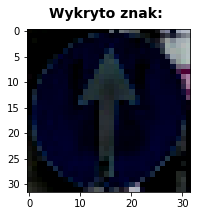

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Nakaz jazdy prosto


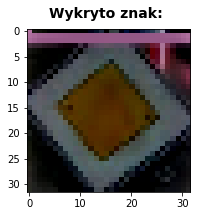

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Droga z pierwszenstwem


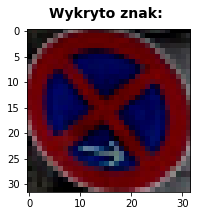

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Nakaz jazdy w lewo (za znakiem)


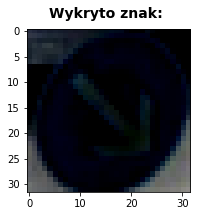

Nakaz jazdy z prawej strony znaku
Szerokość zdjęcia=1841 wysokość=1109


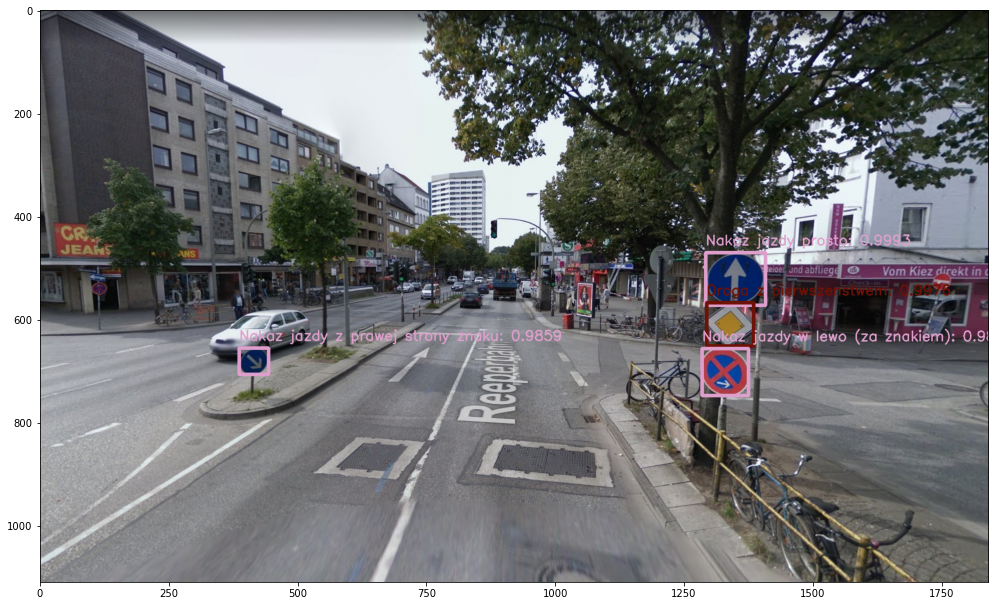

In [35]:
image_BGR = cv2.imread('examples/test_image.jpg')
height, width = image_BGR.shape[:2] 
plt.rcParams['figure.figsize'] = (3, 3)
processing_time = 0
blob = cv2.dnn.blobFromImage(image_BGR, 1 / 255.0, (608, 608), swapRB=True, crop=False)

network.setInput(blob)
start = time.time()
output_from_network = network.forward(layers_names_output)
end = time.time()
processing_time += end - start
print('Czas przetwarzania zdjęcia: {:.5f} s'.format(processing_time))

bounding_boxes = []
confidences = []
class_numbers = []

for result in output_from_network: 
    for detected_objects in result:
        scores = detected_objects[5:]
        class_current = np.argmax(scores)
        confidence_current = scores[class_current]
        
        if confidence_current > probability_minimum:
            box_current = detected_objects[0:4] * np.array([width, height, width, height])
            x_center, y_center, box_width, box_height = box_current
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))

            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)
                
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

if len(results) > 0:
    for i in results.flatten():
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
        
        c_ts = image_BGR[y_min:y_min+int(box_height), x_min:x_min+int(box_width), :]
        if c_ts.shape[:1] == (0,) or c_ts.shape[1:2] == (0,):
            pass
        else:
            plt.suptitle('Wykryto znak:', fontsize=14, fontweight='bold')
            plt.rcParams['figure.figsize'] = (3, 3)
            blob_ts = cv2.dnn.blobFromImage(c_ts, 1 / 255.0, size=(32, 32), swapRB=True, crop=False)
            blob_ts[0] = blob_ts[0, :, :, :] - mean['mean_image_rgb']
            blob_ts = blob_ts.transpose(0, 2, 3, 1)
            plt.imshow(blob_ts[0, :, :, :])
            plt.show()
            scores = model.predict(blob_ts)
            prediction = np.argmax(scores)
            print(labels['SignName'][prediction])
            
            colour_box_current = colours[class_numbers[i]].tolist()
            cv2.rectangle(image_BGR, (x_min, y_min), (x_min + box_width, y_min + box_height), colour_box_current, 6)
            text_box_current = '{}: {:.4f}'.format(labels['SignName'][prediction], confidences[i])
            cv2.putText(image_BGR, text_box_current, (x_min, y_min - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.9, colour_box_current, 2)
            
plt.rcParams['figure.figsize'] = (17, 17)
height, width = image_BGR.shape[:2] 
plt.imshow(cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB))

# Detekcja z kamery wideo
Aby rozpocząć detekcję z kamery wideo, należy uruchomić terminal w katalogu oraz wykonać następujące polecenie:

`python3 webcam_detect.py`